<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train NN</a></span><ul class="toc-item"><li><span><a href="#main():-classifier" data-toc-modified-id="main():-classifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>main(): classifier</a></span></li><li><span><a href="#main():-regressor" data-toc-modified-id="main():-regressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>main(): regressor</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#test-example:-2d" data-toc-modified-id="test-example:-2d-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>test example: 2d</a></span><ul class="toc-item"><li><span><a href="#fully-connected-in-sklearn" data-toc-modified-id="fully-connected-in-sklearn-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>fully connected in sklearn</a></span></li><li><span><a href="#fully-connected-in-keras" data-toc-modified-id="fully-connected-in-keras-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>fully connected in keras</a></span></li><li><span><a href="#cnn" data-toc-modified-id="cnn-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>cnn</a></span></li></ul></li></ul></li></ul></div>

# import libs

In [79]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
list(map(lambda x:sys.path.append(x), confParser['input files']['lib_path'].split()))
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
import pickle
#
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler
#
from scipy.stats import gaussian_kde
#
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)

#--- increase width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

conf. file sections: ['flags', 'input files', 'descriptors', 'neural net', 'neural net classification', 'neural net regression', 'gnn', 'ml mc']


# Train NN

In [80]:
class NeuralNetwork():

    def __init__(self, verbose=False,
                **kwargs
                ):
        self.verbose = verbose
        for key in kwargs:
            setattr(self,key,kwargs[key])
            
            
        !mkdir $self.best_model

    
    def Parse(self,path,nruns):
        self.perAtomData = {}
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            if irun == 0:
                #--- same configurations!
                self.descriptors  = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['data']]
                self.shape        = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['shape']].flatten()
                self.positions    = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['xyz']]
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz .'%(path,irun))
            try:
                data = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                #--- displacement data
                self.perAtomData[irun] = pd.DataFrame(np.c_[data],
                columns='id	type	x	y	z	ux	uy	uz	energy_barrier	defect_label'.split()
                            )
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns = list(self.perAtomData.keys())
        self.nruns.sort()

#     def Junk(self,path,nruns):
#         self.perAtomData = {}
#         self.Descriptors = {}
#         self.Shape       = {}
#         self.Positions   = {}
#         self.Catalogs    = {}
#         #
#         rwjs = utl.ReadWriteJson()
#         for irun in range(nruns):
#             try:
# #                 data_json               = rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]
# #                 self.Descriptors[irun]  = np.c_[data_json['data']]
# #                 self.Shape[irun]        = np.c_[data_json['shape']].flatten()
# #                 self.Positions[irun]    = np.c_[data_json['xyz']]
#                 os.system('ln -s %s/Run%s/dumpFile/dump.xyz ./dump.%s.xyz'%(path,irun,irun))
#                 data                    = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
#                 self.perAtomData[irun]  = pd.DataFrame(np.c_[data],
#                                                        columns ='id type x y z'.split()
#                                                       )
#                 self.Catalogs[irun]     = pd.read_csv('%s/Run%s/catalog.txt'%(path,irun))
#             except:
# #                 if self.verbose:
# #                     traceback.print_exc()
#                 continue
                
        
#         self.nruns     = list(self.perAtomData.keys())
#         self.nruns.sort()

#         self.Descriptors[ 0 ] = pd.DataFrame(np.random.random(size=9876))
#         #--- assert shape and positions are the same for all realizations
# #         self.shape     = self.Shape[ self.nruns[ 0 ] ]
# #         self.positions = self.Positions[ self.nruns[ 0 ] ]

        
        
    def Parse2nd(self,path,nruns):
        self.perAtomData = {}
        self.Descriptors = {}
        self.Shape       = {}
        self.Positions   = {}
        self.Catalogs    = {}
        #
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            try:
                data_json               = rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]
                self.Descriptors[irun]  = np.c_[data_json['data']]
                self.Shape[irun]        = np.c_[data_json['shape']].flatten()
                self.Positions[irun]    = np.c_[data_json['xyz']]
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz ./dump.%s.xyz'%(path,irun,irun))
                data                    = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                self.perAtomData[irun]  = pd.DataFrame(np.c_[data],
                                                       columns ='id type x y z'.split()
                                                      )
                self.Catalogs[irun]     = pd.read_csv('%s/Run%s/catalog.txt'%(path,irun))
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns     = list(self.perAtomData.keys())
        self.nruns.sort()

        #--- assert shape and positions are the same for all realizations
        self.shape     = self.Shape[ self.nruns[ 0 ] ]
        self.positions = self.Positions[ self.nruns[ 0 ] ]
        
    def Combine(self):
        
        if self.verbose:
            print('concatenating descriptors ...')
#         pdb.set_trace()
        #--- center atoms
        center_atom_indices = list(map(lambda x:NeuralNetwork.GetCenterAtom( self.perAtomData[x])[0],self.nruns))
        sdict = dict(zip(center_atom_indices,self.nruns))
        
        atom_ids = list(sdict.keys())
        atom_ids.sort()
        #         center_atom_indices = list( set( center_atom_indices ) )
        data = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[sdict[x]].iloc[ x ]],atom_ids)),axis=1).T
#        descriptors_center_atoms = self.descriptors[atom_ids]
        descriptors_center_atoms = np.c_[list(map(lambda x:self.Descriptors[sdict[x]][x], atom_ids))]
    
        #--- data frame
#        print(data.shape)
        irun = self.nruns[0]
        df_combined = pd.DataFrame(data,columns=list(self.perAtomData[irun].keys()))
    
        #--- filter crystalline atoms
        filtr = self.perAtomData[irun].defect_label == 0.0
        df_crystalline = self.perAtomData[irun][filtr]
        descriptors_crystalline = self.descriptors[filtr]

        #--- merge
        keys = list(df_combined.keys())
        data_concat = np.concatenate([np.c_[df_combined[keys]],np.c_[df_crystalline[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )

        
        #--- merge descriptors
        self.descriptors = np.concatenate([descriptors_center_atoms,descriptors_crystalline],axis=0)

        assert self.perAtomData.shape[ 0 ] == self.descriptors.shape[0], 'need more mc swaps: %s %s'\
        %(self.perAtomData.shape[ 0 ],self.descriptors.shape[0])
                            
    def Combine2nd(self):
        
        if self.verbose:
            print('concatenating descriptors ...')
            
        irun = self.nruns[0]
        keys = list( self.perAtomData[ irun ].keys() )

        #--- center atoms
        data_concat         = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[x]],self.nruns)),axis=0)
        self.perAtomData    = pd.DataFrame(data_concat,
                                 columns=keys
                                )
        self.descriptors    = np.concatenate(list(map(lambda x:self.Descriptors[x], self.nruns)))
    
#     def Junk2nd(self):
        
#         if self.verbose:
#             print('concatenating descriptors ...')
            
#         irun = self.nruns[0]
#         keys = list( self.perAtomData[ irun ].keys() )

#         #--- center atoms
#         data_concat         = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[x]],self.nruns)),axis=0)
#         self.perAtomData    = pd.DataFrame(data_concat,
#                                  columns=keys
#                                 )
#         self.descriptors    = None #self.Descriptors[0]
    
    
    @staticmethod
    def GetCenterAtom(df):
        disp_magnitude = df.ux**2+df.uy**2+df.uz**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)

#     @staticmethod
#     def zscore(slist):
#         tmp = np.copy(slist)
#         print(np.mean(tmp),np.std(tmp))
#         tmp -= np.mean(tmp)
#         tmp /= np.std(tmp)
#         return tmp

    def PCA(self,
           n_components=2,
            random_state = 1,
           ):
        #--- concat. data
        X = self.descriptors
        pca = PCA(n_components=n_components,random_state=random_state)
        pca.fit(X)
        X_transformed = pca.transform(X)

        xdata = X_transformed[:,0]
        ydata = X_transformed[:,1]
        #
        filtr_defects = self.perAtomData.defect_label == 0.0
        #

        legend = utl.Legends()
        legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#         pdb.set_trace()
        #ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
        ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
                  attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                        Plot = False,
        #                 xlim=(-2,2),
        #                 ylim=(-2,2),
                  )

        #utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
        !mkdir png
        utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
                  attrs={'fmt':'.','color':'red','label':'defects'},
                   ax=ax,
                   xstr='pca_1',ystr='pca_2',
                   legend = legend.Get(),
                   title='png/pca.png'
                  )
    def Spectra(self,
               nrows=100,
               ):
        assert nrows <= self.descriptors.shape[ 0 ]
        !mkdir png
        utl.PltBitmap(np.log10(np.abs(self.descriptors[:nrows,:])),
                      xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
                      xlim=(0,self.descriptors.shape[1]),
                      ylim=(0,nrows),
                      colorbar=True,
                      zscore=False,
                      vminmax=(-3,3),
                      title='png/feature_bitmap.png'
                     )
        
    def SklearnMLP(self,X_train,y_train):
        #-----------------------
        #--- parameter grid
        #-----------------------
#         param_grid = {
#                         'hidden_layer_sizes':self.hidden_layer_sizes,
#                          #'activation' : ['tanh', 'relu'],
#                          'learning_rate_init':self.learning_rate_init,
# #                         'alpha':self.alpha, #--- regularization 
#                          #'learning_rate' : ['invscaling', 'adaptive'],
#                         'n_iter_no_change':self.n_iter_no_change,
# #                        'tol':self.tol,
#                         'max_iter':self.max_iter,
#                      } 
        mlp   =  MLPClassifier(random_state=1,
                               hidden_layer_sizes = self.hidden_layer_sizes[0],
                               learning_rate_init = self.learning_rate_init[0],
                               n_iter_no_change   = self.n_iter_no_change[0],
                               max_iter           = self.max_iter[0],
                               verbose=self.verbose)
#         clf  =  GridSearchCV(mlp, param_grid)
#        clf.fit(X_train,y_train)
        mlp.fit(X_train,y_train)
        model =  mlp #clf.best_estimator_
        loss  =  model.loss_curve_
        val_loss = loss
        return (model, loss, val_loss)

    def KerasANN(self, X_train, y_train,X_test, y_test, ndime):

        model     = keras.Sequential([ #--- The network architecture
                                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                #                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                                    layers.Dense(ndime, activation='softmax')
                                    ])
        
#         shape         =  (self.shape[0]*self.shape[1]*self.shape[2],)
#         inputs        =  keras.Input(shape=shape)
#         #------------------------------
#         #--- The network architecture
#         #------------------------------
#         x             =  layers.Dense(   self.hidden_layer_size, activation=self.activation
#                                        )(inputs)
#         for i in range( self.number_hidden_layers ):
#             x       = layers.Dense( self.hidden_layer_size, activation=self.activation
#                                      )(x)
#         #--- output layer
# #         x       = layers.Flatten()(x)
#         outputs = layers.Dense( ndime, activation=self.activation)(x)
#         model   = keras.Model(inputs=inputs, outputs=outputs)

        
        
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate_init) #--- compilation step
        model.compile( optimizer=optimizer,
                       loss="sparse_categorical_crossentropy",
                       metrics=["mse"]
                     )
        #--- save best model
        !mkdir best_model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
#                                                     monitor="mse",
#                                                     save_freq=10,
#                                                     save_best_only=True)]

        model.fit( X_train, y_train, 
           validation_data      = ( X_test, y_test ),
#             callbacks           = callbacks,
            epochs              = self.max_iter[0], 
            verbose             = self.verbose, 
            shuffle             = False, 
#             batch_size     = 32,
#                     use_multiprocessing = True,
#                     workers             = 4,
         )    

        model.save('best_model/convnetClassifier_from_scratch.tf')
        loss      = model.history.history['loss']
        val_loss  = model.history.history['val_loss']
        best_model = model #keras.models.load_model("best_model/convnetClassifier_from_scratch.tf")

        return (best_model, loss, val_loss)

    
    
    @staticmethod
    def MapClassIds( y ):
        ndime         = len(set(y.flatten()))
        class_ids     = list(set(y.flatten()))
        class_ids.sort()
        map_class_ids = dict(zip(class_ids,range(ndime)))        
        return ndime, np.c_[list(map(lambda x:[map_class_ids[x]],y.flatten()))]
    
    @staticmethod
    def GetSubSetCrystallineAtoms(X,y,n_train):
        #--- data frame
        df = pd.DataFrame( y, columns=['topoID'] )
        #--- groups
        sdict = df.groupby(by='topoID').groups
        if sdict[ 0 ].shape[ 0 ] < n_train:
            return X, y
        indices = np.random.choice(sdict[ 0 ], size=n_train, replace=False)
        sdict[ 0 ] = indices
        indices_total = np.concatenate( list(map(lambda x:sdict[x],sdict)) )
        return X[indices_total], y[ indices_total ]
    
    def GetLabels( self, irun ):
        nsize                                  = self.Descriptors[ irun ].shape[ 0 ]
        y_labels                               = np.zeros(nsize,dtype=int)
        nonCrystallineAtomsIndices             = self.Catalogs[ irun ].AtomIndex
        nonCrystallineAtomsTopoIds             = self.Catalogs[ irun ].IniTopoId.astype(int)
        y_labels[ nonCrystallineAtomsIndices ] = nonCrystallineAtomsTopoIds
        return y_labels.reshape( ( nsize, 1 ) )

    
    def TrainClassifier(self,
                       random_state=1,
                       ):
        
#         pdb.set_trace()

        #--- get labels
        y_labels = np.concatenate( list( map(lambda x:self.GetLabels(x), self.nruns ) ) )
        assert self.descriptors.shape[ 0 ] == y_labels.shape[ 0 ]
        
        #--- map topo ids to integers 0, 1 ... ndime
        ndime, y = NeuralNetwork.MapClassIds( y_labels )

        
        X      = np.c_[self.descriptors]

        #--- filter: only train a subset of crystalline atoms
        X, y   = NeuralNetwork.GetSubSetCrystallineAtoms( X, y, self.n_train )
        
        #---------------
        #--- zscore X
        #---------------        
        X      = NeuralNetwork.Zscore( X, save_model = '%s/classifier.sav'%self.best_model )

        #--- add noise
        NeuralNetwork.AddGaussianNoise(X, scale = 0.001 )


        #--- exclude void
#        filtr  = self.perAtomData.type==2
#         X      = X[~filtr]
#         y      = y[~filtr]

        #--- sample from crystalline atoms
        
        #-----------------------
        #--- train-test split
        #-----------------------
#        train_size = self.n_train
#        test_size  = int( self.n_train / 3 )
        assert X.shape[0] >= self.n_train, 'increase nruns!' #train_size + train_size, 'increase nruns!'
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                               test_size=test_size, train_size=train_size,
                                                              random_state=random_state)
        if len(set(y_train.flatten())) < ndime:
            'warning: not every class present in train set!'
        if len(set(y_test.flatten()))  < ndime: 
            'warning: not every class present in test set!'
        
        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                (model, loss, val_loss) = self.SklearnMLP(X_train,y_train)
                classes_x = model.predict(X_test) 
                
            elif self.implementation == 'keras': #--- dense nn in keras
                (model, loss, val_loss) = self.KerasANN(X_train, y_train,X_test, y_test, ndime)
                predict_x = model.predict(X_test) 
                classes_x = np.argmax(predict_x,axis=1)
                
        elif self.cnn: #--- convolutional
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetworkClassifier( y )
            predict_x = model.predict(X_test) 
            classes_x = np.argmax(predict_x,axis=1)
                    
        #--- save loss data
        !mkdir png
        np.savetxt('png/val_loss_classification.txt',
                   np.c_[range(len(loss)),loss,val_loss],
                   header='epoch loss val_loss')

        #--- confusion matrix
        cm = confusion_matrix(y_test, classes_x,
                         labels=range(ndime)
                        )
        np.savetxt('png/confusion.txt',np.c_[cm])

        
    def PrintDescriptors(self,descriptors,y,fout):
        rwjs = utl.ReadWriteJson()
        rwjs.Write([{'descriptors':np.c_[descriptors],
                     'target':np.c_[y],
                     'shape_descriptor':self.shape}],fout)
        

    @staticmethod
    def GetTopoIds( catalog, key ): 
        TopoIds = list( catalog.groupby( by = key ).groups.keys())
        TopoIds.sort()
        return TopoIds 
    
    @staticmethod
    def MapTopoIds( TopoIds ):
        ndime         = len( TopoIds )
        map_TopoIds = dict(zip(TopoIds,range(ndime)))        
        return map_TopoIds

    def GetTopoArrayIndex( self, IniTopoId, FinTopoId ):
        mappedIniTopoId = self.mappedTopoIds[ IniTopoId ]
        mappedFinTopoId = self.mappedTopoIds[ FinTopoId ]
        assert mappedIniTopoId < self.n_unique_transition_paths and\
               mappedFinTopoId < self.n_unique_transition_paths 
        return mappedIniTopoId * self.n_unique_transition_paths * self.ndime + mappedFinTopoId * self.ndime

    def GetTopoArrayIndex2nd( self, ux, uy, uz ):
        aa = np.c_[[ux,uy,uz]].T
        H, bin_edges = np.histogramdd(aa,bins=self.bins)        
        assert H.sum() == 1.0
        
        return H.astype(int).flatten()
        

    def FillTargetMatrix( self, item ):
#        pdb.set_trace()
        ux = item.inifin_dr * item.DirX
        uy = item.inifin_dr * item.DirY
        uz = item.inifin_dr * item.DirZ
        assert np.abs( ux ) < self.umax and\
                np.abs( uy ) < self.umax and\
                np.abs( uz ) < self.umax,'ux=%e, uy=%e, uz=%e increase self.umax!'%(ux,uy,uz)
        irow                                   = int( item.AtomIndex )
#        icol                                   = int( self.GetTopoArrayIndex( item.IniTopoId, item.FinTopoId ) )
        H                                   = self.GetTopoArrayIndex2nd( ux, uy, uz )

        self.y_targets[ irow ] += H           

    def DiscretizeTransitionPath( self ):
         #--- hard-coded values
        xlin = np.arange(-self.umax,+self.umax+self.du,self.du)
        ylin = np.arange(-self.umax,+self.umax+self.du,self.du)
        zlin = np.arange(-self.umax,+self.umax+self.du,self.du)
        self.nbinx = len(xlin)-1
        self.nbiny = len(ylin)-1
        self.nbinz = len(zlin)-1
        self.bins = (xlin, ylin, zlin)
        self.xv, self.yv, self.zv = np.meshgrid( self.bins[1][:-1], self.bins[0][:-1], self.bins[2][:-1] )

#        print(yv[H==1],xv[H==1],zv[H==1])

    def GetTargets( self, irun ):
        #--- set-up y matrix
#         IniTopoId                              = NeuralNetwork.GetTopoIds( self.Catalogs[ irun ], 'IniTopoId' )
#         FinTopoId                              = NeuralNetwork.GetTopoIds( self.Catalogs[ irun ], 'FinTopoId' )
#         TopoIds                                = list( set( FinTopoId + IniTopoId ) ) #--- transition path ids
#         TopoIds.sort()
#         self.mappedTopoIds                     = NeuralNetwork.MapTopoIds( TopoIds )
        
#         self.n_unique_transition_paths         = len( TopoIds )


        nsize                                  = ( self.Descriptors[ irun ].shape[ 0 ], self.nbinx * self.nbiny * self.nbinz )
        self.y_targets                         = np.zeros( nsize[ 0 ] * nsize[ 1 ], dtype=int ).reshape( nsize )
        
        #--- fill y matrix
        self.Catalogs[ irun ].apply( lambda x: self.FillTargetMatrix( x ), axis = 1 )
        
        #--- assert self.y_targets is binary
        assert set(self.y_targets.flatten()) == set(np.array([0,1])), 'decrease du!'
        return self.y_targets
        
    def MaskCrystallineAtoms(self, irun ):
        nsize                              = self.Descriptors[ irun ].shape[ 0 ]
        mask                               = np.zeros(nsize,dtype=bool)
        nonCrystallineAtomsIndices         = np.array( list( set( self.Catalogs[ irun ].AtomIndex ) ) )
        mask[ nonCrystallineAtomsIndices ] = True
        return mask


    def GetInputOutput( self, irun, indx ):
        atomIndices     =  self.Catalogs[ irun ].AtomIndex
        pixel_map_input =  self.Descriptors[ irun ][ atomIndices ]    
        dr              =  np.c_[self.Catalogs[ irun ]['inifin_dr']].flatten()
        dr_multi        = np.c_[ dr, dr, dr ]
        vector_input    =  self.Catalogs[ irun ][ ' DirX      DirY      DirZ'.split() ] * dr_multi
        output          =  self.Catalogs[ irun ][ 'barrier' ]
        return [pixel_map_input, vector_input, output][ indx ]

    def TrainRegressorBarriers(self,
                       random_state=1,
                       ):
        '''
        Multi-layer Perceptron regressor.

        Parameters
        ----------
        stratify : array-like, default=None
        If not None, data is split in a stratified fashion, using this as
        the class labels.
        
        y : array-like, target data
        
        random_state : initial seed, default=1
        
        printOvito : bool, default=False
        
        filtr : bool, default=False
        if not None, data is filtered before calling train-test split
        '''

        
        #--- get transition path bitmap
#        self.DiscretizeTransitionPath()
#        self.ndime                                  = 4 #--- hard-coded: (ux,uy,uz,E)
        pixel_maps_input = np.concatenate( list( map(lambda x:self.GetInputOutput(x,0), self.nruns ) ) )
        vectors_input    = np.concatenate( list( map(lambda x:self.GetInputOutput(x,1), self.nruns ) ) )
        scalar_output    = np.concatenate( list( map(lambda x:self.GetInputOutput(x,2), self.nruns ) ) )

        
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[pixel_maps_input,vectors_input]
        X      = NeuralNetwork.Zscore( X, save_model = '%s/scaler_regression_barriers.sav'%self.best_model )
        y      = np.c_[ scalar_output ]
        
        if X.shape[ 0 ] - self.n_train < 0 :  
            X = NeuralNetwork.Duplicate(X, new_size = self.n_train )
            y = NeuralNetwork.Duplicate(y, new_size = self.n_train )

        #--- add noise
        NeuralNetwork.AddGaussianNoise(X, scale = 0.01 )
        NeuralNetwork.AddGaussianNoise(y, scale = 0.01 )

        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, #stratify=stratify,
                                                            random_state=random_state)


        #-----------------------
        #--- train model
        #-----------------------

                
        (model, loss, val_loss), (X_train, X_test) = self.ConvNetworkMixedInput(X_train, y_train, X_test, y_test )
            
            
            
            #--- validation
        NeuralNetwork.Validation(loss, val_loss, 
                                 model, 
                                 X_train, X_test, y_train, y_test)


    def TrainRegressorTransitionPaths(self,#stratify,y,
                       random_state=1,
                       printOvito = False,
 #                      filtr = None,
                       ):
        '''
        Multi-layer Perceptron regressor.

        Parameters
        ----------
        stratify : array-like, default=None
        If not None, data is split in a stratified fashion, using this as
        the class labels.
        
        y : array-like, target data
        
        random_state : initial seed, default=1
        
        printOvito : bool, default=False
        
        filtr : bool, default=False
        if not None, data is filtered before calling train-test split
        '''

        
        #--- get transition path bitmaps
        self.DiscretizeTransitionPath()
#        self.ndime                                  = 4 #--- hard-coded: (ux,uy,uz,E)
        y = np.concatenate( list( map(lambda x:self.GetTargets(x), self.nruns ) ) )

        
        #--- filtr crystalline atoms
        filtr = np.concatenate( list( map(lambda x:self.MaskCrystallineAtoms(x), self.nruns ) ) )

        y     = y[ filtr ]
        
#        pdb.set_trace()
        
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors[filtr]]
        X      = NeuralNetwork.Zscore( X, save_model = '%s/scaler_regression.sav'%self.best_model )
        
        
        if X.shape[ 0 ] - self.n_train < 0 :  
            X = NeuralNetwork.Duplicate(X, new_size = self.n_train )
            y = NeuralNetwork.Duplicate(y, new_size = self.n_train )

        #--- add noise
        NeuralNetwork.AddGaussianNoise(X, scale = 0.1 )
#        NeuralNetwork.AddGaussianNoise(y, scale = 0.1 )

        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, #stratify=stratify,
                                                            random_state=random_state)


        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                #-----------------------
                #--- parameter grid
                #-----------------------
                param_grid = {
                                'hidden_layer_sizes':self.hidden_layer_sizes,
                                 #'activation' : ['tanh', 'relu'],
                                 'learning_rate_init':self.learning_rate_init,
                                'alpha':self.alpha, #--- regularization 
                                 #'learning_rate' : ['invscaling', 'adaptive'],
                                'n_iter_no_change':self.n_iter_no_change,
                                'tol':self.tol,
                                'max_iter':self.max_iter,
                             } 
                mlp   =  MLPRegressor(random_state=random_state,verbose=self.verbose) #--- mlp regressor
                regr  =  GridSearchCV(mlp, param_grid)
                regr.fit(X_train,y_train)
                model =  regr.best_estimator_
                loss  =  model.loss_curve_
                
            elif self.implementation == 'keras': #--- dense nn in keras
                model     = keras.Sequential([ #--- The network architecture
                    layers.Dense(self.hidden_layer_size, activation=self.activation),
#                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                    layers.Dense(ndime, activation='softmax')
                    ])
                optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_init) #--- compilation step
                model.compile( optimizer=optimizer,#"rmsprop",
                               loss="mean_squared_error",#"sparse_categorical_crossentropy",
                               metrics=["mse"]
                             )
                model.fit(X_train, y_train, #--- “Fitting”
                          validation_data=(X_test, y_test),
                          epochs=self.max_iter[0], verbose=self.verbose, batch_size=1)
                loss      = model.history.history['loss']
                val_loss  = model.history.history['val_loss']
                
        elif self.cnn: #--- convolutional
            
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetworkMultiLabelClassifier(X_train, y_train, X_test, y_test )
            
            NeuralNetwork.ValidationMultiLabelClassification(loss, val_loss, #--- validation
                                 model, 
                                 X_train, X_test, y_train, y_test)
            
#             pdb.set_trace()
#             (model, loss, val_loss), (X_train, X_test) =\
#             self.ConvNetwork(X_train, y_train, X_test, y_test )
            
            
            
            #--- validation
#             NeuralNetwork.Validation(loss, val_loss, 
#                                      model, 
#                                      X_train, X_test, y_train, y_test)
        
        #--- save in ovito file
#         if printOvito:
#             m = self.descriptors.shape[ 0 ]
#             indices = np.arange( m )[ filtr ]
        
#             if indices.shape[ 0 ] - self.n_train < 0 :  
#                 indices = NeuralNetwork.Duplicate(indices, new_size = self.n_train )
            
#             indices_train, indices_test, _, _ = train_test_split(indices, indices, #stratify=stratify,
#                                                                 random_state=random_state)
#             self.PrintOvito( indices_test, model )

    @staticmethod
    def Validation(loss, val_loss, model, X_train, X_test, y_train, y_test):
        #-----------------------
        #--- validation
        #-----------------------
        !mkdir png         #--- plot validation loss 
        ax = utl.PltErr(range(len(val_loss)), val_loss,
                   attrs={'fmt':'-'}, Plot=False,
                  )
        utl.PltErr(range(len(loss)), loss,
                   attrs={'fmt':'-'},
                   ax=ax,
                   yscale='log',xscale='log',
#                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )
        
        np.savetxt('png/loss.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')
        
        
        #--- plot predictions
        y_pred_test  = model.predict(X_test)        
        y_pred_train = model.predict(X_train)        
#         for idime, xstr in zip(range(3),'ux uy uz'.split()):
#             ax = utl.PltErr(None,None,Plot=False)
#             #
#             utl.PltErr(y_test[:,idime],y_pred_test[:,idime],
#                        attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                        ax=ax,
#                        Plot = False,

#                       )
#             #
#             utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
#                        attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                        ax=ax,
#                        Plot = False,

#                       )
#             #
#             utl.PltErr(None,None,Plot=False,
#                            title='png/scatter%s.png'%idime,
#                             ax=ax,
#                        xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                        xlim=(-2,2),ylim=(-2,2),
#                            )

        #--- energy
        idime = 0 #3
        xstr  = 'energy'
        ax = utl.PltErr(None,None,Plot=False)
        #
        utl.PltErr(y_test[:,idime],y_pred_test[:,idime],
                   attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
                   ax=ax,
                   Plot = False,

                  )
        utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
                   attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
                   ax=ax,
                   Plot = False,

                  )
        #
        utl.PltErr(None,None,Plot=False,
                       title='png/scatter%s.png'%idime,
                        ax=ax,
                   xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                   xlim=(-2,2),ylim=(-2,2),
                       )

    @staticmethod
    def ValidationMultiLabelClassification(loss, val_loss, model, X_train, X_test, y_train, y_test):
        #-----------------------
        #--- validation
        #-----------------------
        !mkdir png         #--- plot validation loss 
        ax = utl.PltErr(range(len(val_loss)), val_loss,
                   attrs={'fmt':'-'}, Plot=False,
                  )
        utl.PltErr(range(len(loss)), loss,
                   attrs={'fmt':'-'},
                   ax=ax,
                   yscale='log',xscale='log',
#                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/lossMultiLabelClassification.png',
                  )
        
        np.savetxt('png/lossMultiLabelClassification.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')
        
        
        #--- plot predictions
        y_pred_test              = model.predict(X_test)        
        y_pred_train             = model.predict(X_train)
        
        threshold                = 0.5 #--- hard-coded threshold
        binary_predictions_test  = (y_pred_test > threshold).astype(int)
        binary_predictions_train = (y_pred_train > threshold).astype(int)
        binary_actual_test       = (y_test > threshold).astype(int)
        binary_actual_train      = (y_train > threshold).astype(int)

        
        
        #--- Compute the multilabel confusion matrix
        conf_matrix = multilabel_confusion_matrix( binary_actual_test, binary_predictions_test )
        ndime       = conf_matrix.shape[ 1 ] * conf_matrix.shape[ 2 ]
        conf_matrix = conf_matrix.reshape((conf_matrix.shape[0],ndime))
        np.savetxt('png/confusionMultiLabelClassification.txt',np.c_[conf_matrix])
        
        
        #--- predict displacements
        #--- reshape y_pred
        
            
        
#         disps_predictions_test = np.concatenate([list(map(lambda x: self.GetDispsFromBinaryMaps( x ) , binary_predictions_test ))])
#         disps_actual_test      = np.concatenate([list(map(lambda x: self.GetDispsFromBinaryMaps( x ) , binary_actual_test ))])
        
# #         #--- plot predictions
# #         y_pred_test  = model.predict(X_test)        
# #         y_pred_train = model.predict(X_train)        
#         for idime, xstr in zip(range(3),'ux uy uz'.split()):
#             ax = utl.PltErr(None,None,Plot=False)
#             #
#             utl.PltErr(disps_actual_test[:,idime],disps_predictions_test[:,idime],
#                        attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                        ax=ax,
#                        Plot = False,

#                       )
#             #
# #             utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
# #                        attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
# #                        ax=ax,
# #                        Plot = False,

# #                       )
#             #
#             utl.PltErr(None,None,Plot=False,
#                            title='png/scatter%s.png'%idime,
#                             ax=ax,
#                        xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                        xlim=(-3,3),ylim=(-3,3),
#                            )

    def GetDispsFromBinaryMaps( self, binaryMap ):
        binaryMapReshaped = binaryMap.reshape((self.nbinx, self.nbiny, self.nbinz ))
        filtr = binaryMapReshaped == 1
        return np.c_[self.yv[filtr],self.xv[filtr],self.zv[filtr]]

        
    def PrintOvito( self, filtr, model ):
        #--- save in ovito
        X          = np.c_[self.descriptors[filtr]]
        X          = NeuralNetwork.Zscore( X )
        X_reshaped =  X.reshape((X.shape[0],self.shape[0],self.shape[1],self.shape[2],1))
        y_pred     = model.predict( X_reshaped )
        with open('original.xyz','w') as fp:
            utl.PrintOvito(self.perAtomData.iloc[filtr], fp, '0', attr_list='id type x y z ux uy uz'.split())
        with open('test.xyz','w') as fp:
            xyz = self.perAtomData.iloc[filtr]['id type x y z'.split()]
            cordc = pd.DataFrame(np.c_[xyz,y_pred[:,:3]],columns='id type x y z ux uy uz'.split())
            utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
                

    def ConvNetworkMixedInput(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels: pixel map
        shape_vector_input = 3
        
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ] - shape_vector_input
        pixel_map_input        =  keras.Input(shape=shape)
        vector_input           =  keras.Input(shape=(shape_vector_input,))
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(pixel_map_input)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
        x       = layers.Flatten()(x)
            
        #--- concatenate flattened map with vector
        combined = keras.layers.concatenate( [ x, vector_input ] )
        
        #--- output layer
        outputs = layers.Dense( ndime )( combined ) #, activation=activation)(x)
        model   = keras.Model(inputs=[pixel_map_input,vector_input], outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        model.summary()
        #--- save best model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
#                                                    monitor="loss",
#                                                   save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        nn = X_train.shape[ 1 ]
        X_train_pixels = X_train[:,0:nn-shape_vector_input]
        X_test_pixels  = X_test[:,0:nn-shape_vector_input]
        assert    X_train_pixels.shape[ 1 ] ==    shape[0] * shape[1] * shape[2]
        X_train_vector = X_train[:,nn-shape_vector_input:nn]
        X_test_vector  = X_test[:,nn-shape_vector_input:nn]
        assert    X_train_vector.shape[ 1 ] ==   shape_vector_input
        
    
        X_train_pixels =  X_train_pixels.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_pixels  =  X_test_pixels.reshape((n_test,shape[0],shape[1],shape[2],1))
        
        model.fit( [X_train_pixels,X_train_vector], y_train, 
                   validation_data      = ( [X_test_pixels,X_test_vector], y_test ),
#                    callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                    batch_size          = 1,
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        model.save('best_model/convnetRegressorMixedInput_from_scratch.tf')
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model =model #keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), ([X_train_pixels,X_train_vector], [X_test_pixels,X_test_vector])
    
    def ConvNetwork(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime )( x ) #, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        #--- save best model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
#                                                    monitor="loss",
#                                                   save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
#                    callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                    batch_size          = 1,
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        model.save('best_model/convnetRegressor_from_scratch.tf')
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model =model #keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    
    def ConvNetworkMultiLabelClassifier(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  'relu' #self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation='sigmoid' )( x ) #, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "binary_crossentropy",
                       metrics   =  ["mse"]
                     )

        #--- save best model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
#                                                    monitor="loss",
#                                                   save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
#                    callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                    batch_size          = 1,
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        model.save('best_model/convnetMultiLabelClassifier_from_scratch.tf')
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model =model #keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    
    def ConvNetworkClassifier(self,y,
                               random_state=1
                               ):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
        
        if self.verbose:
            print('dim(y)=',y.shape)
        

        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors ]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        if self.verbose:
            print('X.shape:=',X.shape)
            
            
            
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        
        
        #---- set model parameters
        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step
        model.compile( optimizer =  optimizer,
                       loss=["binary_crossentropy","sparse_categorical_crossentropy"][1],
                       metrics   =  ["mse"]
                     )

        #--- save best model
        !mkdir best_model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
#                                                     monitor="accuracy",
#                                                     save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                   callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        model.save('best_model/convnetClassifier_from_scratch.tf')
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = model #keras.models.load_model("best_model/convnetClassifier_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    

    @staticmethod
    def Duplicate(X, new_size = 100 ):
        m = m0 = X.shape[ 0 ]
#        n = X.shape[ 1 ]
        augmented_x = np.copy( X )

        while m <= new_size:
            augmented_x = np.concatenate([augmented_x,X],axis = 0)
            #
            m = augmented_x.shape[ 0 ]

        assert m > new_size

        return augmented_x[:new_size]

    @staticmethod    
    def AddGaussianNoise(X,scale = 0.1):

        epsilon_x = np.random.normal(scale=scale,size=X.size).reshape(X.shape)
        X += epsilon_x
        
    
    def PrintDensityMap(self, atomIndx, irun, fout):
        with open(fout,'w') as fp:
                    disp           = np.c_[self.perAtomData[ irun ].iloc[atomIndx]['ux uy uz'.split()]].flatten()
                    df             = pd.DataFrame(np.c_[self.Positions[ irun ].T,self.Descriptors[ irun ][atomIndx]],
                                                  columns='x y z mass'.split())
                    utl.PrintOvito(df, fp, 'disp = %s'%disp, attr_list='x y z mass'.split())
                    
    @staticmethod
    def Zscore( X, **kwargs ):
        scaler = StandardScaler()
        scaler.fit(X)
        
        if 'save_model' in kwargs:
            pickle.dump( scaler, open( kwargs[ 'save_model' ], 'wb' ) )
        return scaler.transform( X )

#     def SaveConf(self,fout):
#         with open(fout,'w') as fp:
#             np.savetxt(fp,np.c_[self.perAtomData],header=' '.join(list(self.perAtomData.keys())))

#     def Test(self,y,
#                                    random_state=1
#                                    ):
#             '''
#             Convolutional neural network.

#             Parameters
#             ----------
#             X_train : array-like training x input

#             y_train : array-like, training y input

#             X_test : array-like test x input

#             y_test : array-like, training y input

#             Return
#             ---------- ( , loss,  )
#             best_model : cnn object, best trained model based on on the validation loss

#             loss : array-like, mse loss

#             val_loss : array-like, validation loss

#             '''

#             if self.verbose:
#                 print('dim(y)=',y.shape)

#             ndime  = y.shape[1] #--- dimension of the target vector


#             #---------------
#             #--- zscore X
#             #---------------        
#             X      = np.c_[self.descriptors ]
#             scaler = StandardScaler()
#             scaler.fit(X)
#             X      = scaler.transform( X )

#             if self.verbose:
#                 print('X.shape:=',X.shape)



#             #-----------------------
#             #--- train-test split
#             #-----------------------
#             X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                                 random_state=random_state)



#             #---- set model parameters
#             shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
#             kernel_size   =  self.kernel_size 
#             epochs        =  self.max_iter[0]
#             activation    =  self.activation
#             padding       = 'same'
#             filters       =  self.n_channels
#             learning_rate = self.learning_rate_init[0]
#             #
#             ndime         =  y_train.shape[1]
#             n_train       =  X_train.shape[0]
#             n_test        =  X_test.shape[0]
#             assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
#             inputs        =  keras.Input(shape=shape)
#             #
#     #         pdb.set_trace()
#             #------------------------------
#             #--- The network architecture
#             #------------------------------
#             model     = keras.Sequential([
#                 layers.Dense(self.hidden_layer_size, activation="relu"),
#     #             layers.Dense(self.hidden_layer_size), #activation="relu"),
#                 layers.Dense(2, activation="softmax")
#                 ])
#             optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step

#             model.compile( optimizer="rmsprop",
#                            loss="sparse_categorical_crossentropy",
#                            metrics=["mse"])


#             #--- “Fitting” the model X_train_transfrmd, y_train
#             X_train_reshaped =  X_train 
#             X_test_reshaped  =  X_test
#             model.fit( X_train_reshaped, y_train, 
#                        validation_data      = ( X_test_reshaped, y_test ),
#     #                     callbacks=callbacks,
#                         epochs              = epochs, 
#                         verbose             = self.verbose, 
#                         shuffle             = False, 
#     #                     batch_size     = 128,
#                         use_multiprocessing = True,
#                         workers             = 4,
#                      )        


#             #--- save best model
#             !mkdir best_model
#     #         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
#     #                                                    monitor="val_loss",
#     #                                                   save_freq=10,
#     #                                                     save_best_only=True)]


#             #--- validation loss
#             loss       = model.history.history['loss']
#             val_loss   = model.history.history['val_loss']
#             best_model = model #keras.models.load_model("best_model/convnet_from_scratch.tf")


#             !mkdir png
#             utl.PltErr(range(len(loss)), loss,
#                        yscale='log',
#                        xstr='epoch',ystr='loss',
#                        title='png/loss_classification.png',
#                       )

#     #         pdb.set_trace()
#             #--- confusion matrix
#             cm = confusion_matrix(y_test, model.predict_classes(X_test),
#                              labels=[0, 1]
#                             )
#             print('cm=',cm)
#             np.savetxt('png/confusion.txt',np.c_[cm])


In [81]:
#nn.Catalogs[0]

## main(): classifier

In [82]:
 def main():
 
    if not eval(confParser['neural net classification']['classification']):
        return
    
    nn = NeuralNetwork(
                        hidden_layer_sizes   = eval(confParser['neural net classification']['hidden_layer_sizes']),
                        learning_rate_init   = eval(confParser['neural net classification']['learning_rate_init']),
                        n_iter_no_change     = eval(confParser['neural net classification']['n_iter_no_change']),
                        tol                  = eval(confParser['neural net classification']['tol']),
                        max_iter             = eval(confParser['neural net classification']['max_iter']),
                        alpha                = eval(confParser['neural net classification']['alpha']),
                        hidden_layer_size    = eval(confParser['neural net classification']['hidden_layer_size']),
                        fully_connected      = eval(confParser['neural net classification']['fully_connected']),
                        implementation       = eval(confParser['neural net classification']['implementation']),
                        cnn                  = eval(confParser['neural net classification']['cnn']),
                        n_channels           = eval(confParser['neural net classification']['n_channels']),
                        kernel_size          = eval(confParser['neural net classification']['kernel_size']),
                        activation           = eval(confParser['neural net classification']['activation']),
                        number_hidden_layers = eval(confParser['neural net classification']['number_hidden_layers']),
                        n_train              = eval(confParser['neural net classification']['n_train']),
                        best_model           = 'best_model',
                        verbose              = True 
                    )
    
    nn.Parse2nd( path  = confParser['neural net']['input_path'],
              nruns = eval(confParser['neural net classification']['nruns']))

    nn.Combine2nd() #--- concat. descriptors

    #--- classifier
    nn.TrainClassifier()
#        nn.Test(np.c_[nn.perAtomData.defect_label].astype(int))
    
    
    return nn

#model_clf = main()

## main(): regressor

In [83]:
 def main():
 
    if not eval(confParser['neural net regression']['regression']):
        return

    nn = NeuralNetwork(
                        hidden_layer_sizes   = eval(confParser['neural net regression']['hidden_layer_sizes']),
                        learning_rate_init   = eval(confParser['neural net regression']['learning_rate_init']),
                        n_iter_no_change     = eval(confParser['neural net regression']['n_iter_no_change']),
                        tol                  = eval(confParser['neural net regression']['tol']),
                        max_iter             = eval(confParser['neural net regression']['max_iter']),
                        alpha                = eval(confParser['neural net regression']['alpha']),
                        hidden_layer_size    = eval(confParser['neural net regression']['hidden_layer_size']),
                        fully_connected      = eval(confParser['neural net regression']['fully_connected']),
                        implementation       = eval(confParser['neural net regression']['implementation']),
                        cnn                  = eval(confParser['neural net regression']['cnn']),
                        n_channels           = eval(confParser['neural net regression']['n_channels']),
                        kernel_size          = eval(confParser['neural net regression']['kernel_size']),
                        activation           = eval(confParser['neural net regression']['activation']),
                        number_hidden_layers = eval(confParser['neural net regression']['number_hidden_layers']),
                        n_train              = eval(confParser['neural net regression']['n_train']),
                        du                   = eval(confParser['neural net regression']['du']),
                        umax                 = eval(confParser['neural net regression']['umax']),
                        best_model           = 'best_model',
                        verbose              = True 
                    )
    
    nn.Parse2nd( path  = confParser['neural net']['input_path'],
              nruns = eval(confParser['neural net regression']['nruns']))

    nn.Combine2nd() #--- concat. descriptors

    nn.TrainRegressorTransitionPaths()
    nn.TrainRegressorBarriers()
    
    return nn

#model_regr = main()

### Plot

In [84]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    

    
    #--- ann
    number_hidden_layers  = dict(zip(range(4),[1]))
    hidden_layer_size     = dict(zip(range(4),[1]))
    n_channels            = dict(zip(range(4),[1]))
    activations           = dict(zip(range(20),['relu']))
#     string[ inums ] = "\t\'5\':\'neuralNet/20x20/ann/classifier/layer%s/channel%s/activation%s/layer_size%s\',\n" % (key_n,key_c,key_a,key_h) #--- change job name
    
    #--- cnn
#     number_hidden_layers  = dict(zip(range(4),[1,2,3]))
#     hidden_layer_size     = dict(zip(range(4),[1]))
#     n_channels            = dict(zip(range(4),[8,16,32,64]))
#     activations           = dict(zip(range(20),['linear']))

    runs = range(8)
    
    legend = utl.Legends()
    legend.Set(fontsize=14,bbox_to_anchor=(1.5, 0.3, 0.5, 0.5))
    symbols = utl.Symbols()
    
    nphi = len(number_hidden_layers)
    #---
    count = 0
    ax = utl.PltErr(None, None, Plot=False )
    for key_n in number_hidden_layers:
        number_hidden_layer = number_hidden_layers[key_n]
#         if number_hidden_layer != 2:
#             continue
        for key_c in n_channels:
            n_channel = n_channels[key_c]
#             if n_channel != 16:
#                 continue
            for key_a in activations:
                activation = activations[key_a]
                for key_h in hidden_layer_size:
                    nsize = hidden_layer_size[key_h]

        #---	
#                    path = 'neuralNet/20x20/cnn/classifier/layer%s/channel%s/activation%s/layer_size%s'%(key_n,key_c,key_a,key_h) #--- change job name
                    path = 'neuralNet/ni/interestitials/test2nd' #--- change job name
                    fp = ['confusion.txt', 'val_loss_classification.txt','loss.txt'][ 2 ]
                    for irun in runs:
                        try:
                            data = np.loadtxt('%s/Run%s/png/%s'%(path,irun,fp))
                        except:
                            continue

                        if fp == 'confusion.txt':
                            accuracy_crystals = data[0,0]/np.sum(data[0,:])
                            accuracy_defects = data[1,1]/np.sum(data[1,:])
                            print(data)
                            utl.PltErr(accuracy_crystals, accuracy_defects,
                               attrs=symbols.GetAttrs(count=count%7,nevery=800,
                                    label='%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                                       Plot=False,
                                       ax=ax,
                                       )
                        else:
                            epoch = data[:,0]
                            loss = data[:,1]
                            val_loss = data[:,2]

                            utl.PltErr(epoch, loss,
                               attrs=symbols.GetAttrs(count=count%7,nevery=10,
                                    label='train:%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                                       Plot=False,
                                       ax=ax,
                                       )
                            utl.PltErr(epoch, val_loss,
                               attrs=symbols.GetAttrs(count=(count+1)%7,nevery=10,
                                    label='test:%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                                       Plot=False,
                                       ax=ax,
                                       )
                    count += 1
    ax = utl.PltErr(None, None,
                        yscale='log',xscale='log',
                       xstr='epoch',ystr='validation loss',
#                     ylim=(1e-1,1e1),
                    ax=ax,
                    legend=legend.Get(),
                       title='png/training_loss.png',
                   )


main()

In [85]:
# cm=np.loadtxt('neuralNet/ni/interestitials/test2nd/Run0/png/confusionMultiLabelClassification.txt').astype(int)
# falseNegative = list(map(lambda x: 1.0*x[0]/(x[0]+x[1]), cm))
# truePositive  = list(map(lambda x: 1.0*x[3]/(x[2]+x[3]), cm))
# filtr  = cm[:,3] > 0
# cm[filtr]

In [86]:
# legend = utl.Legends()
# legend.Set(fontsize=14,bbox_to_anchor=(1.5, 0.3, 0.5, 0.5))
# symbols = utl.Symbols()

# fp = ['confusion.txt', 'val_loss_classification.txt'][0]
# data = np.loadtxt('neuralNet/ni/kmc/inactive/Run0/png/%s'%(fp))
# ax = utl.PltErr(None, None, Plot=False )
# if fp == 'confusion.txt':
#     accuracy_crystals = data[0,0]/np.sum(data[0,:])
#     accuracy_defects = data[1,1]/np.sum(data[1,:])
#     print(data)
#     utl.PltErr(accuracy_crystals, accuracy_defects,
#        attrs=symbols.GetAttrs(count=0,nevery=800,
#             ), 
#                Plot=False,
#                ax=ax,
#                )
# else:
#     epoch = data[:,0]
#     loss = data[:,1]
#     val_loss = data[:,2]

#     utl.PltErr(epoch, val_loss,
#        attrs=symbols.GetAttrs(count=0,nevery=10,
#             ), 
#                Plot=False,
#                ax=ax,
#                )
    
# ax = utl.PltErr(None, None,
# yscale='log',xscale='log',
# xstr='epoch',ystr='validation loss',
# #                     ylim=(1e-1,1e1),
# ax=ax,
# # legend=legend.Get(),
# title='png/training_loss.png',
# )

## test example: 2d

In [87]:
# import numpy as np
# y=np.c_[[1.725966,1.725967],
#             [-1.725966,1.725967],
#             [-1.725966,-1.725967],
#             [1.725966,-1.725967],
#            ].T

# X=np.concatenate([list(map(lambda x:np.load('png/descriptor%s.npy'%x).flatten(),range(4)))],axis=1)

# #--- zscore
# scaler = StandardScaler()
# scaler.fit(X)
# X_transfrmd = scaler.transform( X )

# X_train_transfrmd, X_test_transfrmd, y_train, y_test = train_test_split(X_transfrmd, y, test_size=0.25)
# print(y_test)


# print(X_train_transfrmd.shape)

### fully connected in sklearn

In [88]:

# #        pdb.set_trace()
# #--- tune parameters

# #--- train
# mlp = MLPRegressor(random_state=1,
#                     verbose=True,
#                    n_iter_no_change=100000,
#                     max_iter=100,#00,
#                    hidden_layer_sizes=(1000,1000),
# #                    shuffle=False,
# #                     alpha=1e-1,

#                   )
# mlp.fit(X_train_transfrmd,y_train)

# #--- validate
# !mkdir png
# utl.PltErr(range(len(mlp.loss_curve_)), mlp.loss_curve_,
#            attrs={'fmt':'-'},
#            yscale='log',xscale='log',
# #           xlim=(1,self.max_iter[0]),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

# # #         pdb.set_trace()
# y_pred =mlp.predict(X_test_transfrmd)        
# y_pred_train = mlp.predict(X_train_transfrmd)        
# for idime, xstr in zip(range(2),'ux uy'.split()):
#     ax = utl.PltErr(None,None,Plot=False)
#     #
#     utl.PltErr(y_test[:,idime],y_pred[:,idime],
#                attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
#                attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(None,None,Plot=False,
#                    title='png/scatter%s.png'%idime,
#                     ax=ax,
#                xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                xlim=(-3,3),ylim=(-3,3),
#                    )




In [89]:
# mlp.best_loss_, mlp.loss_

In [90]:
# ux,uy=mlp.predict(X_test_transfrmd)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [91]:
# ux,uy

In [92]:
# ax = utl.PltErr(None,None,Plot=False)

# for i in range(2):
#     utl.PltErr(range(data.descriptors[0,:].shape[0]),data.descriptors[i,:],
#               attrs={'fmt':'-'},#,'color':'C0'},
#                xscale='log',yscale='log',
#                ax=ax,
#                Plot=False,
#               )

# utl.PltErr(range(data.descriptors[100,:].shape[0]),data.descriptors[100,:],
#           attrs={'fmt':'-','color':'C0'},
#            xscale='log',yscale='log',
#            ax=ax,
#            Plot=False,
#           )


In [93]:
# data.Spectra(nrows=100)

In [94]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# X, y = make_regression(n_samples=200, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=1)
# regr = MLPRegressor(verbose=False,
#                     random_state=1, 
# #                     learning_rate='adaptive',
# #                    early_stopping=True, 
#                      n_iter_no_change=1, 
#                     tol=1e-2,
#                      max_iter=10000000,
# #                     solver='sgd',
#                    ).fit(X_train, y_train)
# regr.tol


### fully connected in keras

In [95]:
# #--- The network architecture
# model = keras.Sequential([
#     layers.Dense(512), #activation="relu"),
# #     layers.Dense(1000), #activation="relu"),
#     layers.Dense(2) #, activation="relu")
#     ])

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- Preparing the image data
# # train_images = train_images.reshape((60000, 28 * 28))
# # train_images = train_images.astype("float32") / 255
# # test_images = test_images.reshape((10000, 28 * 28))
# # test_images = test_images.astype("float32") / 255

# #--- “Fitting” the model X_train_transfrmd,y_train
# model.fit(X_train_transfrmd, y_train, 
#             validation_data=(X_test_transfrmd, y_test),

#           epochs=100, verbose=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,100),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

### cnn

In [96]:
# tf.random.set_random_seed(812)

# shape=(300,300,1)
# kernel_size = (3,3)
# epochs = 1000
# activation = ['linear','sigmoid','relu'][0]
# padding='same'
# filters = 1
# #
# ndime = y_train.shape[1]
# n_train = X_train_transfrmd.shape[0]
# n_test = X_test_transfrmd.shape[0]
# assert shape[0]*shape[1]*shape[2] == X_train_transfrmd.shape[1]
# inputs = keras.Input(shape=shape)
# #
# x = layers.Conv2D(filters=filters, kernel_size=kernel_size,activation=activation,padding=padding)(inputs)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=2*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=4*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=8*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense( ndime, activation=activation)(x)

# #--- The network architecture
# model = keras.Model(inputs=inputs, outputs=outputs)

# print(model.summary())

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-08)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- save best model 
# callbacks=[keras.callbacks.ModelCheckpoint( filepath='png/convnet_from_scratch.keras',  
#                                            monitor="val_loss",
#                                            save_freq=10,
#                                             save_best_only=True)]

# #--- “Fitting” the model X_train_transfrmd,y_train
# X_train_reshaped = X_train_transfrmd.reshape((n_train,shape[0],shape[1],1))
# X_test_reshaped = X_test_transfrmd.reshape((n_test,shape[0],shape[1],1))
# model.fit(X_train_reshaped, y_train, 
#             validation_data=(X_test_reshaped, y_test),
#             #callbacks=callbacks,
#           epochs=epochs, verbose=False, shuffle=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,epochs),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

In [97]:
#best_model = keras.models.load_model("png/convnet_from_scratch.keras")


In [98]:
# ux,uy=best_model.predict(X_test_reshaped)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [99]:
# (ux,uy), y_test[0]

# gnn

# fixed output size

## build catalog

In [100]:
evlist_dir = '%s/EVLIST_DIR'%confParser['input files']['input_path']
events_dir = '%s/SPEC_EVENTS_DIR'%confParser['input files']['input_path']
lib_path   = confParser['input files']['lib_path'].split()[0] #'../../HeaDef/postprocess'

In [101]:

def ParseEvList_dir():
    files = os.listdir(evlist_dir)
    events={}
    for sfile in files:
        try:
            kmc_step = int(sfile.split('_')[-1])
    #        print(kmc_step)
            filee=open('%s/%s'%(evlist_dir,sfile)) #--- open file
            events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
        except:
            continue
    return events

def ModifyCatalog(  ):
    '''
    Return a dataframe including per-atom energy and defect type 
    '''        
    kmc_step     = 1

    #--- discard refined == False
    filtr = catalog[ kmc_step ].refined == 'T'
    catalog[ kmc_step ] = catalog[ kmc_step ][ filtr ]

    #--- displacements
    fout = 'transition_paths.json'
    os.system('rm %s'%fout)
    catalog[ kmc_step ].apply(lambda x:GetDispForEvents(x,fout),axis=1)

    #--- modify catalog
#     self.catalog[ kmc_step ]['refined'] = 1 #--- add column: 1
#     self.catalog[ kmc_step ][ 'DirX DirY DirZ'.split() ] = np.c_[ list( disps_events ) ] #--- add columns: ux, uy, uz
#     self.catalog[ kmc_step ].reset_index(drop = True, inplace=True) #--- reset index

#     #--- add atom indices
#     AtomIds     = np.c_[self.catalog[ kmc_step ].AtomId].astype(int).flatten() #--- add atom index
#     AtomIndices = EnergyBarrier.GetDataFrameIndex(self.perAtomData, key='id', val=AtomIds)
#     self.catalog[ kmc_step ]['AtomIndex'] = AtomIndices

def GetDispForEvents( item, fout ):
    #--- parse spec_event file including the diffusion path
    try:
        diffusion_path_dict = ParseSpecEvents_dir( '%s/spec_event_%s_%s_0'\
                                                                %( events_dir, item.AtomId, item.Spec_id ) ) 
        diffusion_path_xyz = Displacement( '%s/spec_event_%s_%s_0.xyz'\
                                                                 %( events_dir, item.AtomId, item.Spec_id ), 'junk.xyz' ) 
        assert diffusion_path_dict[ 'active_atom_label' ] == int( item.AtomId )
        assert diffusion_path_dict[ 'Spec_eventId' ]      == int( item.Spec_id )
        assert diffusion_path_dict[ 'Original_eventId' ]  == int( item.eventId )
        assert diffusion_path_dict[ 'event_label' ][ 0 ]  == int( item.IniTopoId ) and\
               diffusion_path_dict[ 'event_label' ][ 1 ]  == int( item.SadTopoId ) and\
               diffusion_path_dict[ 'event_label' ][ 2 ]  == int( item.FinTopoId ) 

        #--- save as json
        with open(fout,'a') as fp:
            rwjs = utl.ReadWriteJson(append=True)
            rwjs.Write( [diffusion_path_xyz.to_dict()], fp )
        
        return diffusion_path_dict[ 'delr_main_atom' ]
    except:
        traceback.print_exc()
        return [np.nan, np.nan, np.nan ]

def ParseSpecEvents_dir(fp):
    '''
    return energy barriers associated with hopping events
    '''
    with open( fp ) as filee: #'%s/%s'%(self.events_dir,sfile)) #--- open file
        xstrs             = filee.readlines()
        Spec_eventId      = int(xstrs[0].split()[-1]) #--- specific event id
        Original_eventId  = int(xstrs[1].split()[-1]) #--- Original eventId
        Refinement_step   = int(xstrs[2].split()[-1]) #--- Original eventId
        event_label       = list(map(int,xstrs[3].split()[-1:-4:-1])) #--- Original eventId
        energy_barrier    = float(xstrs[4].split()[-1]) #--- energy
        delr_main_atom    = list(map(float,xstrs[12].split()[-1:-4:-1]))                 
        active_atom_label = int(xstrs[15].split()[-1])

    event_label.reverse()
    delr_main_atom.reverse()
    return {'Spec_eventId':Spec_eventId, 'Original_eventId':Original_eventId, 'Refinement_step':Refinement_step,\
            'event_label':event_label,   'energy_barrier':energy_barrier,     'delr_main_atom':delr_main_atom,\
            'active_atom_label':active_atom_label}
        
def Displacement(fp, fout,verbose=True):
    '''
    Return total displacements 
    '''
    !rm $fout
#    pdb.set_trace()
    #--- fetch parameters

    #--- call ovito
    t0 = time.time()
    if verbose:
        print('input :%s'%fp)
    os.system('ovitos %s/OvitosCna.py %s %s 1 7 %s'%(lib_path,fp,fout,'header.txt'))
    if verbose:
        print('output disp:%s s'%(time.time()-t0))

    #--- parse disp files
    if verbose:
        print('parsing %s'%fout)
    t0 = time.time()
    lmpDisp = lp.ReadDumpFile( fout )
    lmpDisp.GetCords( ncount = sys.maxsize )
    if verbose:
        print('elapsed time %s s'%(time.time()-t0))
        display(lmpDisp.coord_atoms_broken[0].head())
    
    dispSad = lmpDisp.coord_atoms_broken[1]['x y z'.split()] - lmpDisp.coord_atoms_broken[0]['x y z'.split()]
    dispFin = lmpDisp.coord_atoms_broken[2]['x y z'.split()] - lmpDisp.coord_atoms_broken[0]['x y z'.split()]
    idType_xyz = lmpDisp.coord_atoms_broken[0]['id type x y z'.split()]
    df = pd.DataFrame(np.c_[idType_xyz, dispSad,dispFin],columns='id type x y z ux_sad uy_sad uz_sad ux_fin uy_fin uz_fin'.split())
    
    return df
            
catalog          = ParseEvList_dir()
ModifyCatalog()
#catalog[1]

rm: junk.xyz: No such file or directory
input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_135_1_0.xyz
output disp:3.899477958679199 s
parsing junk.xyz
elapsed time 0.034010887145996094 s


,id,type,x,y,z
0,1,1,0.000000,0.000000,3.520380
1,2,1,0.000000,3.520380,0.000000
2,3,1,0.000000,-0.010411,-3.551225
3,4,1,0.000000,-3.551225,-0.010411
4,5,1,-3.537112,-0.007376,-0.007376


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_136_1_0.xyz
output disp:1.5025091171264648 s
parsing junk.xyz
elapsed time 0.009266853332519531 s


,id,type,x,y,z
0,1,1,0.000000,0.000000,3.520380
1,2,1,3.520380,0.000000,0.000000
2,3,1,-0.010411,0.000000,-3.551225
3,4,1,-3.551225,0.000000,-0.010411
4,5,1,-0.007376,-3.537112,-0.007376


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_140_1_0.xyz
output disp:1.3091959953308105 s
parsing junk.xyz
elapsed time 0.009696006774902344 s


,id,type,x,y,z
0,1,1,-3.520380,0.000000,0.000000
1,2,1,0.000000,0.000000,3.520380
2,3,1,3.551225,0.000000,-0.010411
3,4,1,0.010411,0.000000,-3.551225
4,5,1,0.007376,-3.537112,-0.007376


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_155_1_0.xyz
output disp:1.9590892791748047 s
parsing junk.xyz
elapsed time 0.03179025650024414 s


,id,type,x,y,z
0,1,1,0.000000,-3.520380,0.000000
1,2,1,0.000000,0.000000,3.520380
2,3,1,0.000000,3.551225,-0.010411
3,4,1,0.000000,0.010411,-3.551225
4,5,1,-3.537112,0.007376,-0.007376


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_233_1_0.xyz
output disp:1.0455858707427979 s
parsing junk.xyz
elapsed time 0.09363627433776855 s


,id,type,x,y,z
0,1,1,0.000000,3.520380,0.000000
1,2,1,3.520380,0.000000,0.000000
2,3,1,-0.010411,-3.551225,0.000000
3,4,1,-3.551225,-0.010411,0.000000
4,5,1,-0.007376,-0.007376,-3.537112


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_234_1_0.xyz
output disp:0.8603792190551758 s
parsing junk.xyz
elapsed time 0.01347208023071289 s


,id,type,x,y,z
0,1,1,0.000000,0.000000,-3.520380
1,2,1,0.000000,3.520380,0.000000
2,3,1,0.000000,-0.010411,3.551225
3,4,1,0.000000,-3.551225,0.010411
4,5,1,-3.537112,-0.007376,0.007376


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_235_1_0.xyz
output disp:1.2264249324798584 s
parsing junk.xyz
elapsed time 0.008865833282470703 s


,id,type,x,y,z
0,1,1,0.000000,0.000000,-3.520380
1,2,1,3.520380,0.000000,0.000000
2,3,1,-0.010411,0.000000,3.551225
3,4,1,-3.551225,0.000000,0.010411
4,5,1,-0.007376,-3.537112,0.007376


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_236_1_0.xyz
output disp:0.8771510124206543 s
parsing junk.xyz
elapsed time 0.008526086807250977 s


,id,type,x,y,z
0,1,1,-3.520380,0.000000,0.000000
1,2,1,0.000000,3.520380,0.000000
2,3,1,3.551225,-0.010411,0.000000
3,4,1,0.010411,-3.551225,0.000000
4,5,1,0.007376,-0.007376,-3.537112


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_239_1_0.xyz
output disp:1.000929832458496 s
parsing junk.xyz
elapsed time 0.009063243865966797 s


,id,type,x,y,z
0,1,1,-3.520380,0.000000,0.000000
1,2,1,0.000000,0.000000,-3.520380
2,3,1,3.551225,0.000000,0.010411
3,4,1,0.010411,0.000000,3.551225
4,5,1,0.007376,-3.537112,0.007376


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_252_1_0.xyz
output disp:1.1703450679779053 s
parsing junk.xyz
elapsed time 0.013833045959472656 s


,id,type,x,y,z
0,1,1,0.000000,-3.520380,0.000000
1,2,1,3.520380,0.000000,0.000000
2,3,1,-0.010411,3.551225,0.000000
3,4,1,-3.551225,0.010411,0.000000
4,5,1,-0.007376,0.007376,-3.537112


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_254_1_0.xyz
output disp:1.1971960067749023 s
parsing junk.xyz
elapsed time 0.0110321044921875 s


,id,type,x,y,z
0,1,1,0.000000,-3.520380,0.000000
1,2,1,0.000000,0.000000,-3.520380
2,3,1,0.000000,3.551225,0.010411
3,4,1,0.000000,0.010411,3.551225
4,5,1,-3.537112,0.007376,0.007376


input :../simulations/ni/pure/test/Run0/SPEC_EVENTS_DIR/spec_event_256_1_0.xyz
output disp:1.1886210441589355 s
parsing junk.xyz
elapsed time 0.008410215377807617 s


,id,type,x,y,z
0,1,1,-3.520380,0.000000,0.000000
1,2,1,0.000000,-3.520380,0.000000
2,3,1,3.551225,0.010411,0.000000
3,4,1,0.010411,3.551225,0.000000
4,5,1,0.007376,0.007376,-3.537112


In [102]:
rwjs = utl.ReadWriteJson()
transition_paths = rwjs.Read( 'transition_paths.json' )
pd.DataFrame(transition_paths[ 1 ])

,id,type,x,y,z,ux_sad,uy_sad,uz_sad,ux_fin,uy_fin,uz_fin
0,1.0,1.0,0.000000,0.000000,3.520380,0.026960,2.710000e-06,-0.066493,-0.010883,-0.000002,0.016851
1,2.0,1.0,3.520380,0.000000,0.000000,-0.066401,-4.377000e-05,0.027027,0.016856,-0.000005,-0.010880
2,3.0,1.0,-0.010411,0.000000,-3.551225,0.009176,-4.112000e-05,0.012709,-0.000283,-0.000004,-0.007821
3,4.0,1.0,-3.551225,0.000000,-0.010411,0.012597,7.000000e-07,0.009154,-0.007829,-0.000001,-0.000284
4,5.0,1.0,-0.007376,-3.537112,-0.007376,-0.014014,-6.602020e-02,-0.013971,-0.003582,-0.014026,-0.003578
5,6.0,1.0,-0.007376,3.537112,-0.007376,-0.013940,6.597610e-02,-0.013986,-0.003577,0.014020,-0.003579
6,7.0,1.0,0.000000,-1.760190,1.760190,-0.043298,-1.720990e-01,0.033284,-0.011148,-0.001658,-0.011207
7,8.0,1.0,0.000000,1.760190,1.760190,-0.043249,1.720758e-01,0.033277,-0.011146,0.001653,-0.011208
8,9.0,1.0,1.760190,-1.760190,0.000000,0.033322,-1.721280e-01,-0.043224,-0.011204,-0.001661,-0.011144
9,10.0,1.0,1.760190,1.760190,0.000000,0.033366,1.720518e-01,-0.043227,-0.011202,0.001653,-0.011145


In [103]:
!rm 'ovito.xyz'
for indx, item in enumerate( transition_paths ):
    cordc = pd.DataFrame(item)
    with open('ovito.xyz','a') as fp: 
        utl.PrintOvito(cordc, fp, 'itime=%s'%indx, attr_list='id type x y z ux_fin uy_fin uz_fin'.split())


## graph net

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



class GraphNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dims, activation):
        super(GraphNeuralNet, self).__init__()
        self.output_dims = output_dims
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.fc_out = nn.ModuleList([nn.Linear(hidden_dims[-1], dim) for dim in output_dims])
        self.activation = activation

    def forward(self, x, adj_matrices):
        x = self.activation(self.fc1(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        outputs = []
        for adj_matrix in adj_matrices:
            hidden = torch.matmul(adj_matrix, x)
            for fc_out in self.fc_out:
                outputs.append(fc_out(hidden))
        return outputs





    
def compute_adjacency_matrices(input_data, rcut):
    adj_matrices = []
    
    for positions in input_data:
        num_atoms = positions.shape[0]
        adj_matrix = torch.zeros((num_atoms, num_atoms), dtype=torch.float)
        
        for i in range(num_atoms):
            for j in range(i + 1, num_atoms):
                distance = torch.norm(positions[i] - positions[j])
                if distance <= rcut:
                    adj_matrix[i, j] = 1
                    adj_matrix[j, i] = 1
            assert adj_matrix[i,:].sum() > 0, 'dangling node : increase the cutoff!'
        adj_matrices.append(adj_matrix)
    
    #--- assert no 
    return adj_matrices


def augment_data(input_data, target_displacements, noise_std):
    augmented_input_data = []
    augmented_target_displacements = []

    for data, target in zip(input_data, target_displacements):
        # Add Gaussian noise to input data
        noisy_data = data + torch.randn_like(data) * noise_std
        augmented_input_data.append(noisy_data)

        # Add Gaussian noise to target displacements
        noisy_target = target + torch.randn_like(target) * noise_std
        augmented_target_displacements.append(noisy_target)

    return augmented_input_data, augmented_target_displacements

def standardize_data(data, mean, std):
    return (data - mean) / std



    

In [214]:
def main(): # Example usage
    input_dim = eval(confParser['gnn']['input_dim']) #3  # Dimensionality of atom positions (e.g., x, y, z coordinates)
    hidden_dim = eval(confParser['gnn']['hidden_dim']) #[64]  # Dimensionality of hidden layers
    output_dims = eval(confParser['gnn']['output_dims']) #[3]  # Dimensionality of displacement vectors for each snapshot
    activation = eval(confParser['gnn']['activation']) #nn.ReLU() #nn.Identity()) #F.relu)
    lr = eval(confParser['gnn']['lr'])# 1.0e-4
    ntrain = eval(confParser['gnn']['ntrain'])#100
    num_epochs = eval(confParser['gnn']['num_epochs'])#20000
    noise_std   = eval(confParser['gnn']['noise_std'])#0.1

    num_snapshots = len( transition_paths )
    snapshots     = range(num_snapshots)

    model = GraphNeuralNet(input_dim, hidden_dim, output_dims,activation) #


    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Example training data
    num_atoms = [ len(transition_paths[ i ]['id']) for i in snapshots ]
    input_data = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  



    # Example target data (displacement vectors for each snapshot and each path)
    target_displacements = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] ).float() for i in snapshots for dim in output_dims]


    # Augment the dataset to have order 100 snapshots
    augmented_input_data = []
    augmented_target_displacements = []
    input_data_tensor = torch.stack(input_data)
    ntrain_initial = input_data_tensor.shape[0]*input_data_tensor.shape[1]
    n_repeat = np.max([1,int(ntrain/ntrain_initial)])

    for _ in range(n_repeat):  # Repeat the augmentation process 10 times
        augmented_input, augmented_target = augment_data(input_data, target_displacements, noise_std)
        augmented_input_data.extend(augmented_input)
        augmented_target_displacements.extend(augmented_target)

    adj_matrices = compute_adjacency_matrices(augmented_input_data, rcut=3.0) #[torch.randint(0, 2, (num_atoms[i], num_atoms[i])).float() for i in range(num_snapshots)]  # Random adjacency matrices for each snapshot



    # Concatenate input data along a new dimension to form a single tensor
    input_data_tensor = torch.stack(augmented_input_data)
    print('input_data_tensor.shape:',input_data_tensor.shape)

    # Standardize the augmented input data
    mean = input_data_tensor.mean(dim=(0, 1))
    std = input_data_tensor.std(dim=(0, 1))
    standardized_input_data = [standardize_data(data, mean, std) for data in augmented_input_data]


    # Convert input data to tensors
    #input_data_tensor = torch.stack(augmented_input_data)
    target_displacements_tensor = torch.stack(augmented_target_displacements)

    total_loss_hist = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        predicted_displacements = model(input_data_tensor, adj_matrices)
    #    predicted_displacements_tensor = torch.stack( predicted_displacements )
        losses = []
        for indx, i in enumerate(snapshots):
            pred = predicted_displacements[ indx ][ indx ]
            snapshot_losses = criterion(pred, augmented_target_displacements[indx])
    #        snapshot_losses = [criterion(pred, augmented_target_displacements[indx]) for pred in predicted_displacements[indx]]
    #        pdb.set_trace()
            losses.append(snapshot_losses)
    #        losses.extend(snapshot_losses)
    #    loss = criterion(predicted_displacements_tensor, target_displacements_tensor)
        total_loss = sum(losses)
        total_loss.backward()
    #    loss.backward()
        optimizer.step()
        total_loss_hist += [total_loss.detach().numpy()]
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Total Loss: {total_loss.item()}')

#main()

In [215]:
# for p in model.parameters():
#     print(p.shape)

In [216]:
# ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d',)

# irun=6
# xyz = input_data_tensor[irun] 
# adj_mat = adj_matrices[irun]


# ax.plot(xyz[:,0],xyz[:,1],xyz[:,2],
#         '.', ms=20,
#         )

# n=adj_mat.shape[0]
# for i,item in enumerate(adj_mat):
#     for j in range(i,n):
#         if item[j]:
#             ax.plot([xyz[i,0],xyz[j,0]],[xyz[i,1],xyz[j,1]],[xyz[i,2],xyz[j,2]],
#                     '-', color='black',
#                     )

# u = augmented_target_displacements[irun][-1]

# ax.plot([xyz[-1,0],u[0]],[xyz[-1,1],u[1]],[xyz[-1,2],u[2]],
#         '-', color='red',
#         )


## mpnn

In [76]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd

# class MPNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(MPNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)

#     def message_passing_layer(self, x, adj_matrices):
#         # Ensure adj_matrices is a list of tensors
#         adj_matrices = [adj.unsqueeze(0) for adj in adj_matrices]

#         # Expand node features to include neighboring node features
# #        expanded_x = [torch.matmul(adj.unsqueeze(0), x.unsqueeze(0)).squeeze(0) for adj in adj_matrices]
#         expanded_x = [torch.matmul(adj,yy) for adj, yy in zip(adj_matrices,x)]
# #        expanded_x = [torch.matmul(adj.unsqueeze(0), adj).squeeze(0) for adj in adj_matrices]

#         # Concatenate node features with neighboring node features
#         pdb.set_trace()
#         concatenated_x = [torch.cat((x, exp_x), dim=1) for exp_x in expanded_x]

#         # Apply linear transformation
#         transformed_x = [self.fc1(cat_x) for cat_x in concatenated_x]

#         # Apply activation function
#         x = [F.relu(trans_x) for trans_x in transformed_x]

#         return x


#     def readout_layer(self, x):
#         # Concatenate tensors in the list along the batch dimension
#         concatenated_x = torch.stack(x, dim=0)

#         # Apply global pooling operation (e.g., mean or sum) along the batch dimension
#         return torch.mean(concatenated_x, dim=0)

#     def forward(self, x, adj_matrices):
#         x = self.message_passing_layer(x, adj_matrices)
#         output = self.readout_layer(x)
#         return output

# # Example usage
# input_dim = 3  # Dimensionality of atom positions (e.g., x, y, z coordinates)
# hidden_dim = 64  # Dimensionality of hidden layers
# output_dim = 3  # Dimensionality of displacement vectors for each snapshot

# # Create model instance
# model = MPNN(input_dim, hidden_dim, output_dim)

# # Define optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=1.0e-4)
# criterion = nn.MSELoss()

# # Example training data
# # Assuming input_data is a list of tensors containing initial positions for each snapshot
# # Assuming adj_matrices is a list of adjacency matrices for each snapshot
# # Assuming target_displacements is a list of tensors containing displacement vectors for each snapshot
# # You need to replace these with your actual data
# input_data = [torch.randn(10, input_dim).float() for _ in range(10)]  # Example random initial positions
# adj_matrices = [torch.randint(0, 2, (10, 10)).float() for _ in range(10)]  # Example random adjacency matrices
# target_displacements = [torch.randn(10, output_dim) for _ in range(10)]  # Example random target displacements

# # Training loop
# num_epochs = 1000
# for epoch in range(num_epochs):
#     optimizer.zero_grad()
#     predicted_displacements = model(input_data, adj_matrices)
#     loss = criterion(predicted_displacements, target_displacements)
#     loss.backward()
#     optimizer.step()
#     if epoch % 100 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')


## tf

In [213]:
import tensorflow as tf

class GraphNeuralNetwork(tf.keras.Model):
    def __init__(self, hidden_dim, output_dim):
        super(GraphNeuralNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Define layers
        self.fc1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.fc2 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.fc_out = tf.keras.layers.Dense(output_dim)

    def call(self, x, adj_matrices):
        # x: Node features (batch_size, num_nodes, input_dim)
        # adj_matrices: Adjacency matrices (batch_size, num_nodes, num_nodes)
        
        # Apply first fully connected layer
        x = self.fc1(x)
        
        # Iterate over adjacency matrices and update node features
        for adj_matrix in adj_matrices:
            x = tf.matmul(adj_matrix, x)
            x = self.fc2(x)
        
        # Apply output fully connected layer
        output = self.fc_out(x)
        
        return output

def compute_adjacency_matrices(input_data, rcut):
    adj_matrices = []
    
    for positions in input_data:
        num_atoms = positions.shape[0]
        adj_matrix = np.zeros(num_atoms*num_atoms).reshape((num_atoms, num_atoms))
        
        for i in range(num_atoms):
            for j in range(i + 1, num_atoms):
                distance = torch.norm(positions[i] - positions[j])
                if distance <= rcut:
                    adj_matrix[i, j] = 1
                    adj_matrix[j, i] = 1
            assert adj_matrix[i,:].sum() > 0, 'dangling node : increase the cutoff!'
        adj_matrices.append(adj_matrix)
    
    #--- assert no 
    return np.c_[adj_matrices]

def main():
    # Example usage
    hidden_dim = 32  # Dimensionality of hidden layers
    output_dim = 3  # Dimensionality of output vectors
    snapshots = range(len(transition_paths))

    model = GraphNeuralNetwork(hidden_dim, output_dim)

    # Define optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Generate dummy input data and adjacency matrices
#     batch_size = 2
#     num_nodes = 10
    input_dim = 3

    #x = tf.random.normal((batch_size, num_nodes, input_dim))
    x = np.c_[[np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] for i in snapshots]]
    x = tf.convert_to_tensor(x,dtype=tf.float32)

    #adj_matrices = tf.random.uniform((batch_size, num_nodes, num_nodes)) # for _ in range(2)]  # Example with 2 adjacency matrices
    input_data = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  
    adj_matrices = compute_adjacency_matrices(torch.stack(input_data), rcut=3.0)
    adj_matrices = tf.convert_to_tensor(adj_matrices,dtype=tf.float32)

    # Example target data
    #target = tf.random.normal((batch_size, num_nodes, output_dim))
    target = np.c_[[np.c_[pd.DataFrame(transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] for i in snapshots]]
    target = tf.convert_to_tensor(target,dtype=tf.float32)


    # Training loop
    total_loss_hist = []
    num_epochs = 100000
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            predictions = model(x, adj_matrices)
    #         pdb.set_trace()
            loss = loss_fn(target, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        

        if epoch % 10 == 0: 
            total_loss_hist.append(loss.numpy())
            print('Epoch %s, Loss: %e'%(epoch,loss.numpy()))
    
    return model, num_epochs, total_loss_hist

model, num_epochs, total_loss_hist = main()

NotImplementedError: tf.GradientTape.gradients() does not support graph control flow operations like tf.cond or tf.while at this time. Use tf.gradients() instead. If you need this feature, please file a feature request at https://github.com/tensorflow/tensorflow/issues/new

mkdir: png: File exists


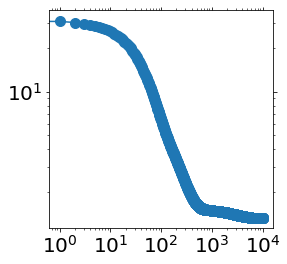

<AxesSubplot:>

In [107]:
!mkdir png
utl.PltErr(range(num_epochs),total_loss_hist,
          xscale='log',yscale='log',
           title='png/loss.png'
          )

<AxesSubplot:>

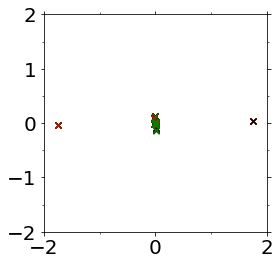

In [109]:
def make_prediction(model, input_data, adj_matrices, target_displacements):
    ax = utl.PltErr(None,None,Plot=False)
    predicted_displacements = model(input_data, adj_matrices)
    for i_snapshot,u_pred in enumerate(predicted_displacements):
        
        u_act  = target_displacements[i_snapshot]

        colors='black red green'.split()
        for idime in range(3):
            utl.PltErr(u_act[:,idime],u_pred[:,idime],
                   attrs={'fmt':'x','color':colors[idime]},
                  ax=ax, Plot=False,
                  )

        utl.PltErr( None,None,
                   Plot=False,
        ax=ax,
                #xlim=(-2,2),ylim=(-2,2),
                   title='png/disp.png'
                  )


snapshots = range(len(transition_paths))
x = np.c_[[np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] for i in snapshots]]
x = tf.convert_to_tensor(x,dtype=tf.float32)

#adj_matrices = tf.random.uniform((batch_size, num_nodes, num_nodes)) # for _ in range(2)]  # Example with 2 adjacency matrices
input_data = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  
adj_matrices = compute_adjacency_matrices(torch.stack(input_data), rcut=3.0)
adj_matrices = tf.convert_to_tensor(adj_matrices,dtype=tf.float32)

# Example target data
#target = tf.random.normal((batch_size, num_nodes, output_dim))
target = np.c_[[np.c_[pd.DataFrame(transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] for i in snapshots]]
target = tf.convert_to_tensor(target,dtype=tf.float32)


make_prediction(model, x, adj_matrices, target)

